## Import des librairies ##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import History,LearningRateScheduler
from  tensorflow.keras.layers import Dropout
print('TensorFlow %s, Keras %s, numpy %s, pandas %s'%(tf.__version__,keras.__version__, np.__version__,pd.__version__))
__DEBUG__=False


TensorFlow 1.9.0, Keras 2.1.6-tf, numpy 1.14.2, pandas 0.22.0


## Paramètres ##

In [2]:
## Structure du réseau et nombre d'epochs (nombre de fois où on passe sur le DataSet)
num_hidden_layers=4
first_layer_size = 128
other_layer_size = 512
epochs=50

###Valeurs A tester dans la cross validation
lst_init_learning_rate = [0.01,0.003, 0.1] 
lst_dropout_prob=[0.15,0.05]
n_splits=10

## Fonctions ##

In [3]:
def get_columns_metadata(df, lst_cols):       
     header_df = pd.DataFrame( data = lst_cols, columns=['var_name'])    
     header_df['mean']=df[lst_cols].mean().values
     header_df['min']= df[lst_cols].min().values
     header_df['max']= df[lst_cols].max().values
     header_df.set_index('var_name',inplace=True)
     return header_df

def normalize(df,header_df):
    for col in df.columns:
        print(col,col in header_df.index )
        if col in header_df.index : 
### Ici normùaliser chaque  colonne. Pour l'instant on ne fait rien
            df[col] = df[col]

## lecture des données ##

In [4]:
train = pd.read_csv('Data/passagers.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('Data/test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]
finalfile_index=test.PassengerId #Index des données de test pour le résultat final
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Analyse des données #

## 1. Pclass ##
Impact de la classe sur la Survie.

In [5]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2. Sex ##
Impact du genre sur la Survie.

In [6]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch ##
Impacte de la taille de la famille.

In [7]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


Introduction d'une distinction sur les personnes seules

In [8]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


## 4. Embarked ##
Impact du Port d'embarquement sur la Survie.

In [9]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Fare ##
On remplace les valeurs manquantes par la moyenne. Puis on regarde l'impact du prix du ticket

In [10]:
for dataset in full_data:
    dataset.loc[dataset.Fare.isnull(), 'Fare'] = train['Fare'].mean()
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


## 6. Age ##
Pour les valeurs vides, on gnère des ages aléatoires entre (mean - std) and (mean + std).
Ensuite on analyse l'impact

In [11]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    #dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset.loc[np.isnan(dataset['Age']),'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.513514
1   (16.0, 32.0]  0.358621
2   (32.0, 48.0]  0.369811
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


# Mise en Forme des données #

In [12]:
for dataset in full_data:
    # Traitement variable 'Sex'
    dataset['Sex'].replace('female',0,inplace=True )
    dataset['Sex'].replace('male',1,inplace=True)
    
   # Traitement variable 'Embarked'
    dataset['Embarked'].replace('S',0,inplace=True)
    dataset['Embarked'].replace('C',1,inplace=True)
    dataset['Embarked'].replace('Q',2,inplace=True)    

# Suppression des colonnes inutiles
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

### N'oubliez pas de mettre à jour la fonction normalize !
header_df=get_columns_metadata(train,list(train.columns.values)) 
normalize(train,header_df)

test  = test.drop(drop_elements, axis = 1)
normalize(test,header_df)

print (train.head(10))
print (test.head(10))

Survived True
Pclass True
Sex True
Age True
Fare True
Embarked True
IsAlone True
Pclass True
Sex True
Age True
Fare True
Embarked True
IsAlone True
   Survived  Pclass  Sex  Age     Fare  Embarked  IsAlone
0         0       3    1   22   7.2500         0        0
1         1       1    0   38  71.2833         1        0
2         1       3    0   26   7.9250         0        1
3         1       1    0   35  53.1000         0        0
4         0       3    1   35   8.0500         0        1
5         0       3    1   39   8.4583         2        1
6         0       1    1   54  51.8625         0        1
7         0       3    1    2  21.0750         0        0
8         1       3    0   27  11.1333         0        0
9         1       2    0   14  30.0708         1        0
   Pclass  Sex  Age     Fare  Embarked  IsAlone
0       3    1   34   7.8292         2        1
1       3    0   47   7.0000         0        0
2       2    1   62   9.6875         2        1
3       3    1   27   

## Création du modèle et initialisation Training ##

In [13]:
def set_model(init_learning_rate,dropout_prob):
    model = keras.Sequential()
    model.add(keras.layers.Dense(first_layer_size, activation='relu'))
### Ajouter ici une ligne  pour gérer le sur-apprentissage
    #Couche cachées
    for i in range(num_hidden_layers):
        # Adds a densely-connected layer  to the model:
        model.add(keras.layers.Dense(other_layer_size, activation='relu'))
### Ajouter ici une ligne  pour gérer le sur-apprentissage
    # Couche de Sortie:
    model.add(keras.layers.Dense(2, activation='softmax'))    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step,1000, 0.96, staircase=True)
### Ici vous pouvez essayer différents algos de descentes de gradients 
    model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate),#RMSPropOptimizer(learning_rate), #GradientDescentOptimizer(learning_rate),AdamOptimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Vérification du Sur-Apprentissage ##

position_validation_data= 712


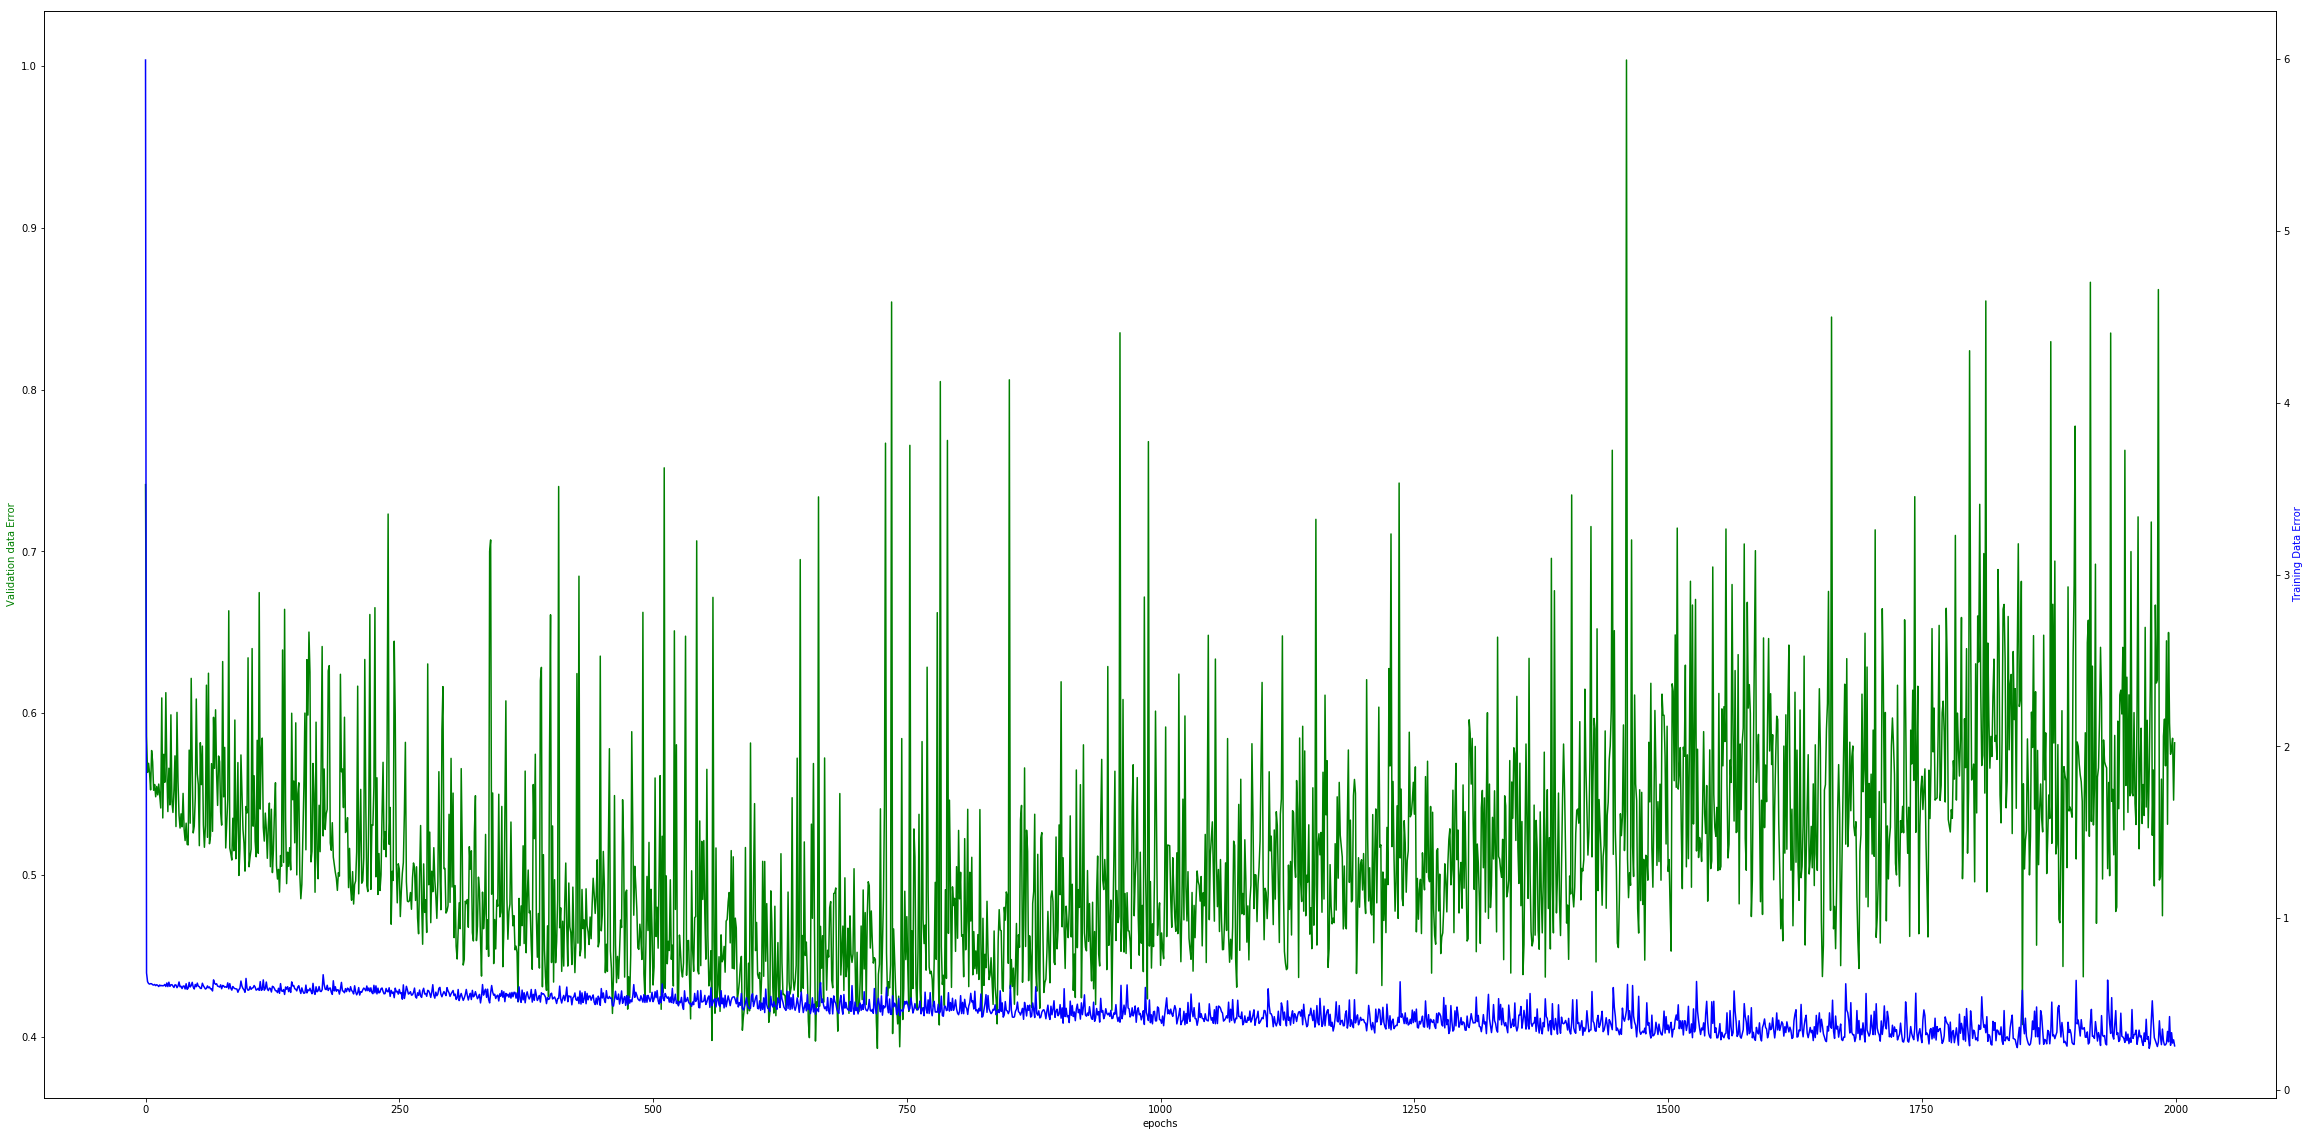

In [20]:

###Essayez Différents jeu de paramètre pour réduire le sur-appentissage
init_learning_rate=0.1
dropout_prob= 0
epochs=2000
pourcentage_validation= 0.2
lst_col=list(train.columns.values)
lst_col.remove('Survived')

X=train[lst_col]
y=train['Survived']

position_validation_data=int(train.shape[0] * (1-pourcentage_validation))
print('position_validation_data=',position_validation_data)
X_train, X_test = X[lst_col][:position_validation_data].values, X[lst_col][position_validation_data:].values
y_train, y_test = np.transpose([1-y[:position_validation_data], y[:position_validation_data]]), \
                  np.transpose([1-y[position_validation_data:], y[position_validation_data:]]) 


model = set_model(init_learning_rate,dropout_prob) 
hist = History()
model.fit(X_train, y_train, epochs=epochs, batch_size=128,validation_data=(X_test, y_test),verbose=False, callbacks=[hist])

plt.rcParams["figure.figsize"] = (40,20)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(hist.history['val_loss'], color= 'g')
ax2.plot(hist.history['loss'], color= 'b')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Validation data Error', color='g')
ax2.set_ylabel('Training Data Error', color='b')
plt.show()
                                 

## Fonction de cross validation ##

In [ ]:
def cv_run(model, name, sss):
   
    loop=1
    for train_index, test_index in sss.split(X, y):
### A vous de completer les 2 lignes ci-dessous
        # X_train, X_test = 
        # y_train, y_test = 

        hist = History()
        model.fit(X_train, y_train, epochs=epochs, batch_size=32,validation_data=(X_test, y_test),verbose=False, callbacks=[hist])
        [loss, acc] = model.evaluate(X_test, y_test, batch_size=32,verbose=False)    

        if name in acc_dict:
          acc_dict[name] += acc
          loss_dict[name] += loss
        else:
          acc_dict[name] = acc
          loss_dict[name] = loss
        print(loop,':',[loss, acc])
        loop+=1    

## Hyperparemetrage ##

In [ ]:
X = train.values[0::, 1::]
y = train.values[0::, 0]

model_dict={}

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=0)

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
for init_learning_rate in lst_init_learning_rate:
    for dropout_prob in  lst_dropout_prob :
        acc_dict = {}
        loss_dict = {}
        name="lr_%s_do_%s"%(init_learning_rate,dropout_prob)
        model = set_model(init_learning_rate,dropout_prob) 
        model_dict[name]=model
        cv_run(model, name, sss)        
        for clf in acc_dict:
            acc_dict[clf] = acc_dict[clf] / n_splits
            log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
            log = log.append(log_entry)
print (log.values)

# Prediction #
Maintenant on utilise le meilleur jeu de paramètre pour faire la prédiction

In [ ]:
###A vous de completer les 3 lignes ci-dessous, sans oublier la normalisation !

# best_model = model_dict[ ??? ]
# X = ???
# y = ???

y_hot = np.transpose([1-y, y])

best_model.fit(X,y_hot, epochs=epochs, batch_size=32,verbose=False)
print(pd.DataFrame(best_model.evaluate(X, y_hot, batch_size=32,verbose=False),index=model.metrics_names))

prediction=best_model.predict(test.values, batch_size=32)
results=pd.DataFrame(np.argmax(prediction,axis=1), index = finalfile_index, columns=['Survived'])
results.to_csv('resultats.csv')
print(results.sum())
results.describe()